In [4]:
from datasets import load_dataset
import pandas as pd 

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

2023-07-05 09:49:23.586806: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 09:49:23.626498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 09:49:23.821981: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 09:49:23.823260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 09:49:25.117256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Data Imports and Setup

In [5]:
data = load_dataset('nanyy1025/covid_fake_news')
data

Found cached dataset csv (/home/koechian/.cache/huggingface/datasets/nanyy1025___csv/nanyy1025--covid_fake_news-4b03a39bb1c8264f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 6420
    })
    validation: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 2140
    })
    test: Dataset({
        features: ['id', 'tweet', 'label'],
        num_rows: 2140
    })
})

In [7]:
train_texts = data['train']['tweet']
train_labels = data['train']['label']

val_texts = data['validation']['tweet']
val_labels = data['validation']['label']

test_texts = data['test']['tweet']
test_labels = data['test']['label']

In [8]:
df = pd.DataFrame()
df['text'] = train_texts+ val_texts+test_texts
df["label"]= train_labels+val_labels+test_labels

df.head()

,text,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


## Data Preprocessing

In [9]:
# Encoding the data by adding another Colummn Y and adding 1 when the text is real and 0 when false

def enc(label):
    return 1 if label == 'real' else 0

df['y'] = df['label'].apply(lambda x: enc(x))

In [10]:
df['text'] = df['text'].str.replace('@','')
df['text'] = df['text'].str.replace('#','')
df['text'] = df['text'].str.replace('\d+','')
df['text'] = df['text'].str.replace('\s+',' ')
df['text'] = df['text'].str.lower()

df.head()

/tmp/ipykernel_11629/1716086974.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+','')
/tmp/ipykernel_11629/1716086974.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\s+',' ')


,text,label,y
0,the cdc currently reports deaths. in general t...,real,1
1,states reported deaths a small rise from last ...,real,1
2,politically correct woman (almost) uses pandem...,fake,0
3,indiafightscorona: we have covid testing labor...,real,1
4,populous states can generate large case counts...,real,1


## Model Trainning

In [11]:
# Train Test Splits
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'],df['y'],test_size=0.2, random_state=42)

In [12]:
tokeniser = Tokenizer()
tokeniser.fit_on_texts(train_texts)

train_seq = tokeniser.texts_to_sequences(train_texts)
test_seq  = tokeniser.texts_to_sequences(test_texts)


In [13]:
max_len = max(max(map(len, train_seq)), max(map(len,train_seq)))
max_len

1625

In [14]:
train_data = pad_sequences(train_seq,max_len)
test_data = pad_sequences(test_seq,max_len)

## Modelling

In [15]:
model = Sequential()
model.add(Embedding(len(tokeniser.word_index) + 1, 50, input_length = max_len))
model.add(LSTM(128))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2023-07-05 09:49:53.905556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 09:49:53.908394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 09:49:53.910405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [22]:
history = model.fit(train_data, train_labels, validation_data = (test_data,test_labels), epochs = 5, batch_size = 64)

Epoch 1/5


2023-07-05 09:51:02.231785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 09:51:02.236340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 09:51:02.239695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - 227s 2s/step - loss: 0.3399 - accuracy: 0.8498 - val_loss: 0.1893 - val_accuracy: 0.9201
Epoch 2/5
134/134 [==============================] - 223s 2s/step - loss: 0.0910 - accuracy: 0.9692 - val_loss: 0.1542 - val_accuracy: 0.9364
Epoch 3/5
134/134 [==============================] - 250s 2s/step - loss: 0.0272 - accuracy: 0.9925 - val_loss: 0.1960 - val_accuracy: 0.9383
Epoch 4/5
134/134 [==============================] - 250s 2s/step - loss: 0.0186 - accuracy: 0.9947 - val_loss: 0.2769 - val_accuracy: 0.9369
Epoch 5/5
134/134 [==============================] - 239s 2s/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.2332 - val_accuracy: 0.9383


## Evaluation 

Capturing loss and accuracy

In [23]:
loss, acc = model.evaluate(test_data, test_labels)

print(loss)
print(acc)

67/67 [==============================] - 16s 233ms/step - loss: 0.2332 - accuracy: 0.9383
0.2332475781440735
0.9383177757263184


In [24]:
# Plotting the change of Accuracy and loss over time
import matplotlib.pyplot as plt 

def plot(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

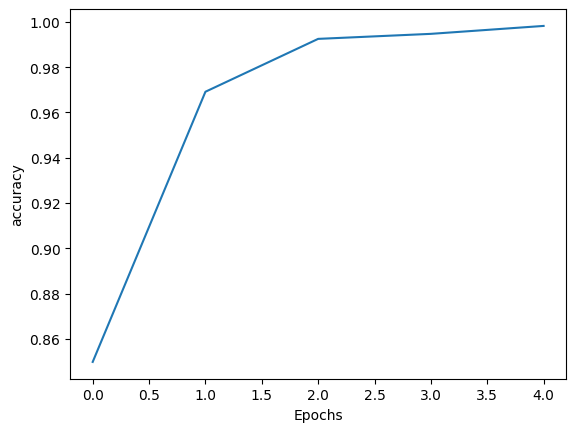

In [25]:
plot(history, "accuracy")

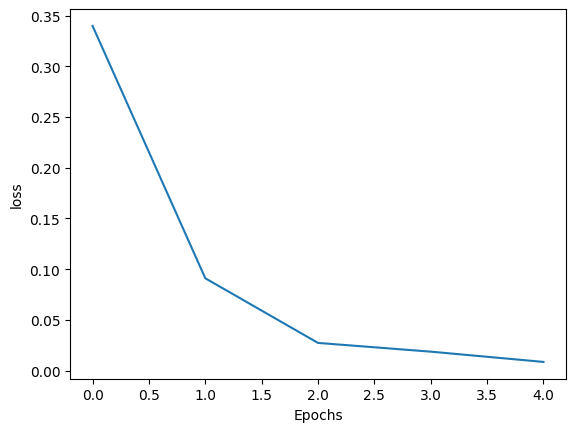

In [26]:
plot(history, "loss")

## Deployment

In [32]:
import numpy as np 

def clf(model, token, text):
    seq = token.texts_to_sequences(text)
    seq = pad_sequences(seq, maxlen = model.input_shape[1])

    pred = model.predict(seq)
    pred_label = np.round(pred[0].astype(int))

    if pred_label ==0:
        return 'Fake News'
    else:
        return 'Real News'

In [28]:
# exporting the model 

model.save('model.h5')

from tensorflow.keras.models import load_model

model2 = load_model('model.h5')

2023-07-05 10:45:23.745856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-05 10:45:23.747534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-05 10:45:23.750290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [38]:
s_text = str(input("Enter a news item:"))
pred = clf(model2, tokeniser, s_text)

print(pred)

3/3 [==============================] - 2s 667ms/step
Fake News
